# 1. Data Information

In [1]:
import numpy as np
import pandas as pd

train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
train.head(5)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [2]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.6+ KB


# 2. Preprocessing data 

In [3]:
# %load functions.py
def process_missing(df):
    """Handle various missing values from the data set

    Usage
    ------

    holdout = process_missing(holdout)
    """
    df["Fare"] = df["Fare"].fillna(train["Fare"].mean())
    df["Embarked"] = df["Embarked"].fillna("S")
    return df

def process_age(df):
    """Process the Age column into pre-defined 'bins' 

    Usage
    ------

    train = process_age(train)
    """
    df["Age"] = df["Age"].fillna(-0.5)
    cut_points = [-1,0,5,12,18,35,60,100]
    label_names = ["Missing","Infant","Child","Teenager","Young Adult","Adult","Senior"]
    df["Age_categories"] = pd.cut(df["Age"],cut_points,labels=label_names)
    return df

def process_fare(df):
    """Process the Fare column into pre-defined 'bins' 

    Usage
    ------

    train = process_fare(train)
    """
    cut_points = [-1,12,50,100,1000]
    label_names = ["0-12","12-50","50-100","100+"]
    df["Fare_categories"] = pd.cut(df["Fare"],cut_points,labels=label_names)
    return df

def process_cabin(df):
    """Process the Cabin column into pre-defined 'bins' 

    Usage
    ------

    train process_cabin(train)
    """
    df["Cabin_type"] = df["Cabin"].str[0]
    df["Cabin_type"] = df["Cabin_type"].fillna("Unknown")
    df = df.drop('Cabin',axis=1)
    return df

def process_titles(df):
    """Extract and categorize the title from the name column 

    Usage
    ------

    train = process_titles(train)
    """
    titles = {
        "Mr" :         "Mr",
        "Mme":         "Mrs",
        "Ms":          "Mrs",
        "Mrs" :        "Mrs",
        "Master" :     "Master",
        "Mlle":        "Miss",
        "Miss" :       "Miss",
        "Capt":        "Officer",
        "Col":         "Officer",
        "Major":       "Officer",
        "Dr":          "Officer",
        "Rev":         "Officer",
        "Jonkheer":    "Royalty",
        "Don":         "Royalty",
        "Sir" :        "Royalty",
        "Countess":    "Royalty",
        "Dona":        "Royalty",
        "Lady" :       "Royalty"
    }
    extracted_titles = df["Name"].str.extract(' ([A-Za-z]+)\.',expand=False)
    df["Title"] = extracted_titles.map(titles)
    return df

def create_dummies(df,column_name):
    """Create Dummy Columns (One Hot Encoding) from a single Column

    Usage
    ------

    train = create_dummies(train,"Age")
    """
    dummies = pd.get_dummies(df[column_name],prefix=column_name)
    df = pd.concat([df,dummies],axis=1)
    df = df.drop(column_name, axis=1)
    return df


In [4]:

def preprocess(df):
    df = process_missing(df)
    df = process_age(df)
    df = process_fare(df)
    df = process_titles(df)
    df = process_cabin(df)
    df = create_dummies(df, ['Age_categories', 'Fare_categories', 'Title', 'Cabin_type', 'Sex'])
    return df

In [5]:
train = preprocess(train)
test = preprocess(test)

In [6]:
print(len(train.columns))
print(len(test.columns))

38
36


In [7]:
col1 = set(train.columns)
col2 = set(test.columns)
col1 - col2

{'Cabin_type_T', 'Survived'}

In [8]:
test['Cabin_type_T'] = 0
print(len(train.columns))
print(len(test.columns))

38
37


# 3. Exploring data

## 3.1 Function 

In [15]:
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
def plot_data_col(df, target_col, num_bin):
    g = sns.FacetGrid(df, col='Survived')
    g.map(plt.hist, target_col, bins=num_bin)
    plt.show()   

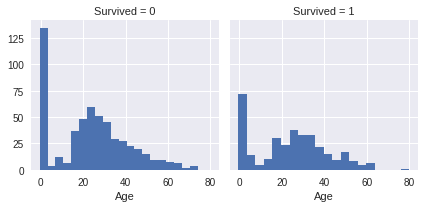

In [13]:
plot_data(train, 'Age', 20)

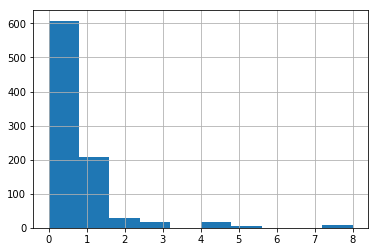

In [10]:
import matplotlib.pyplot as plt
%matplotlib inline

train['SibSp'].hist()

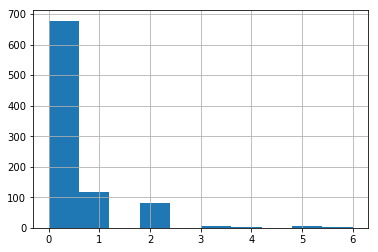

In [11]:
train['Parch'].hist()

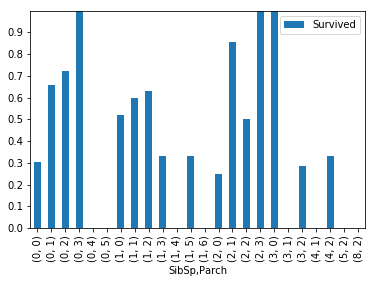

In [12]:
explore_cols = ["SibSp","Parch","Survived"]
explore = train[explore_cols].copy()

explore['familysize'] = explore[["SibSp","Parch"]].sum(axis=1)
pivot = explore.pivot_table(index=["SibSp","Parch"],values="Survived")
pivot.plot.bar(ylim=(0,1),yticks=np.arange(0,1,.1))
plt.show()

In [13]:
def isalone(row):
    if row['SibSp'] + row['Parch'] == 0:
        return 1
    else: 
        return 0
    
train['isalone'] = train.apply(isalone, axis=1)
test['isalone'] = test.apply(isalone, axis=1)

In [14]:
train = train.drop(['SibSp', 'Parch'], axis=1)
test = test.drop(['SibSp', 'Parch'], axis=1)
print(len(train.columns))
print(len(test.columns))

37
36


In [15]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 37 columns):
PassengerId                   891 non-null int64
Survived                      891 non-null int64
Pclass                        891 non-null int64
Name                          891 non-null object
Age                           891 non-null float64
Ticket                        891 non-null object
Fare                          891 non-null float64
Embarked                      891 non-null object
Age_categories_Adult          891 non-null uint8
Age_categories_Child          891 non-null uint8
Age_categories_Infant         891 non-null uint8
Age_categories_Missing        891 non-null uint8
Age_categories_Senior         891 non-null uint8
Age_categories_Teenager       891 non-null uint8
Age_categories_Young Adult    891 non-null uint8
Fare_categories_0-12          891 non-null uint8
Fare_categories_100+          891 non-null uint8
Fare_categories_12-50         891 non-null uint8
Fare_c

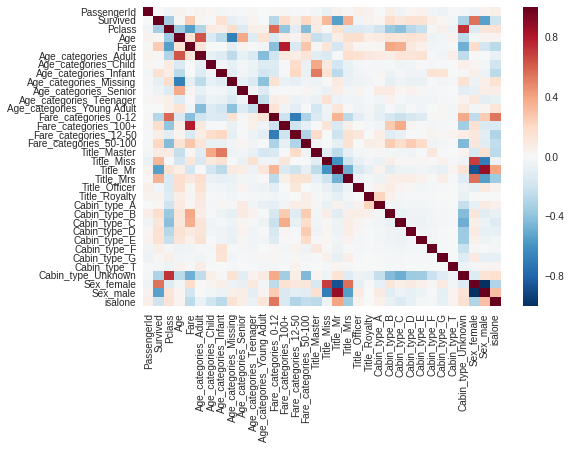

In [16]:
from seaborn import heatmap
corr = train.corr()
heatmap(corr)
plt.show()


To avoid colinearity:

1. Sex_male & Title_Mr 
2. Sex_male & Sex_female
3. remove fare, age, PassengerId,

In [18]:
drop_cols = ['PassengerId', 'Sex_male', 'Title_Mr', 'Fare', 'Age']
train = train.drop(drop_cols, axis=1)
test = test.drop(drop_cols, axis=1)

In [21]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 32 columns):
Survived                      891 non-null int64
Pclass                        891 non-null int64
Name                          891 non-null object
Ticket                        891 non-null object
Embarked                      891 non-null object
Age_categories_Adult          891 non-null uint8
Age_categories_Child          891 non-null uint8
Age_categories_Infant         891 non-null uint8
Age_categories_Missing        891 non-null uint8
Age_categories_Senior         891 non-null uint8
Age_categories_Teenager       891 non-null uint8
Age_categories_Young Adult    891 non-null uint8
Fare_categories_0-12          891 non-null uint8
Fare_categories_100+          891 non-null uint8
Fare_categories_12-50         891 non-null uint8
Fare_categories_50-100        891 non-null uint8
Title_Master                  891 non-null uint8
Title_Miss                    891 non-null uint8
Title_Mrs 

#  4. Feature selection and model selection

## 4.1 Functions  

In [64]:
def select_features(df, init_model):
    df = df.dropna(axis=1)
    df = df.select_dtypes([np.int64, np.float64, np.uint8])
    columns = list(df.columns)
    columns.remove('Survived')
    all_x = df[columns]
    all_y = df['Survived']
    selector = RFECV(init_model, cv=10 )
    selector.fit(all_x, all_y)
    best_cols = all_x.columns[selector.support_]
    return list(best_cols)

def select_model_params(df, best_cols, init_model, hyper_dict):
    all_x = df[best_cols]
    all_y = df['Survived']
    grid = GridSearchCV(init_model, param_grid=hyper_dict, cv=10)
    grid.fit(all_x, all_y)
    best_params = grid.best_params_
    best_score = grid.best_score_
    return best_params, best_score

def model_params(df, modelname, hyper_dict):
    if modelname == 'rfc':
        init_model = RandomForestClassifier()
    elif modelname == 'lr':
        init_model = LogisticRegression()
    else:
        init_model = KNeighborsClassifier()
    best_features = select_features(df, init_model)
    best_params, score = select_model_params(df, best_features, init_model, hyper_dict)
    return best_features, best_params


def model_to_file(model, best_features, filename):
    model.fit(train[best_features], train['Survived'])
    prections = model.predict(test)   
    id_data = pd.read_csv('test.csv')
    test_id = id_data['PassengerId']
    submission_df = {'PassengerId':test_id, 'Survived':predictions}
    submission = pd.DataFrame(submission_df)
    submission.to_csv(filename, index=False)

## 4.2 Models 

### RandomForest 

In [59]:
hyper_lr = {"solver": ["newton-cg", "lbfgs", "liblinear"] }
hyper_knn = {"n_neighbors": range(1,20,2), "weights": ["distance", "uniform"], "algorithm": ["ball_tree", "kd_tree", "brute"], "p": [1,2]}
hyper_rfc = {"n_estimators": [4, 6, 9],"criterion": ["entropy", "gini"],"max_depth": [2, 5, 10],  "max_features": ["log2", "sqrt"], "min_samples_leaf": [1, 5, 8], "min_samples_split": [2, 3, 5]}
best_features, best_params = model_params(train, 'rfc', hyper_rfc)
best_params

{'criterion': 'entropy',
 'max_depth': 10,
 'max_features': 'log2',
 'min_samples_leaf': 1,
 'min_samples_split': 3,
 'n_estimators': 4}

In [65]:
model = RandomForestClassifier(min_samples_leaf=1, n_estimators=4, min_samples_split = 3, criterion='entropy', max_features='log2', max_depth=10)
model_to_file(model, best_features, 'rfc.csv')

### Logistic Regression 

In [74]:
best_features, best_params = model_params(train, 'lr', hyper_lr)
best_params

{'solver': 'newton-cg'}

In [75]:
model = LogisticRegression(solver='newton-cg')
model_to_file(model, best_features, 'lr.csv')

# 5. Result

result:
    1. rfc: 0.76076
    2. lr: 0.76076